In [25]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [26]:
%matplotlib widget

## Rs with empkep

In [27]:
res_prefix = 'bs_empkep_results'

### Some functions

In [28]:
def emp_kep(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

In [29]:
def log_likelihood(params, Y1, Y2, s1, s2, model):
    
    lg_N, T = params
    N = 10**lg_N     # We convert lg_N back to N


    # Y1 --> Tb(3-2), Y2 --> Tb(2-1)
    Y1_predicted = model.get_intensity(line = 'c18o', Ju = 3, Ncol = N, Tex = T, delv = 0.5, Xconv = 1.e-7)
    Y2_predicted = model.get_intensity(line = 'c18o', Ju = 2, Ncol = N, Tex = T, delv = 0.5, Xconv = 1.e-7)


    #print(f" Y1 = {Y1:.1f}, Y1_pred = {Y1_predicted:.1f}")
    # Compute the log likelihood using normal distributions
    log_likelihood_Y1 = -0.5 * (np.log(2 * np.pi * s1**2) + (Y1 - Y1_predicted)**2 / s1**2)
    log_likelihood_Y2 = -0.5 * (np.log(2 * np.pi * s2**2) + (Y2 - Y2_predicted)**2 / s2**2)
    
    lg_l = log_likelihood_Y1 + log_likelihood_Y2
    return lg_l

In [30]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e25]) # cm^-2  
    Texes = np.array([5, Texe[1], 60]) # K
    dv = [15735.077, 10490.369]

    fig, ax = model.makegrid(lines = 'c18o', J1 = 3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []

    for nc in Ncol:
        for te in Texe:
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc, Tex = te, delv = 15735.077, Xconv=1.e-7))

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    
    for nc in Ncol:
        for te in Texe:
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc, Tex = te, delv = 10490.369, Xconv=1.e-7))
    
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    ax.scatter(tb7, tb6, color = 'red', marker = 'o', s=50, facecolors='none', 
               edgecolors='r', label = 'Observed')
    
    plt.legend(prop={'size': 6})

    return fig, ax

### Temperature estimation 

#### Read the Data

In [31]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [32]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep, get_surrounding_pix = False, mode='func',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep, get_surrounding_pix = False, mode='func',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})

#### Data Visualization

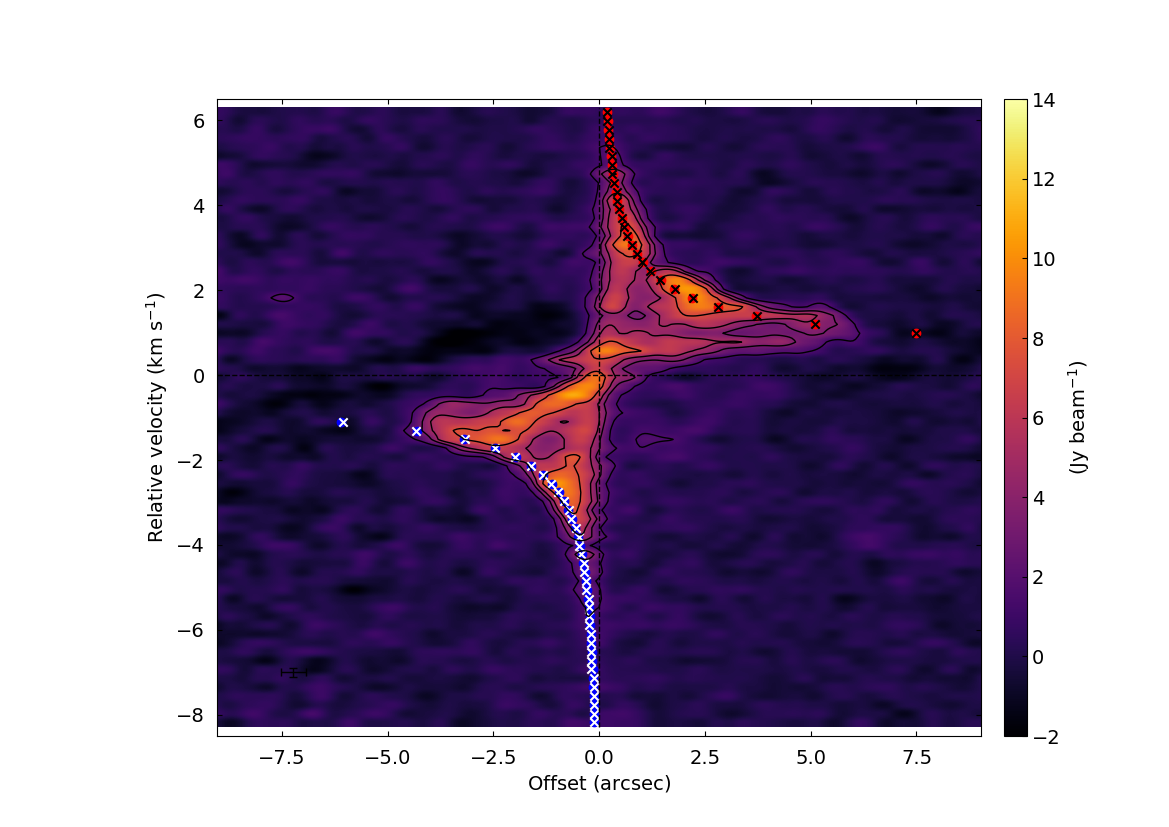

In [33]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)

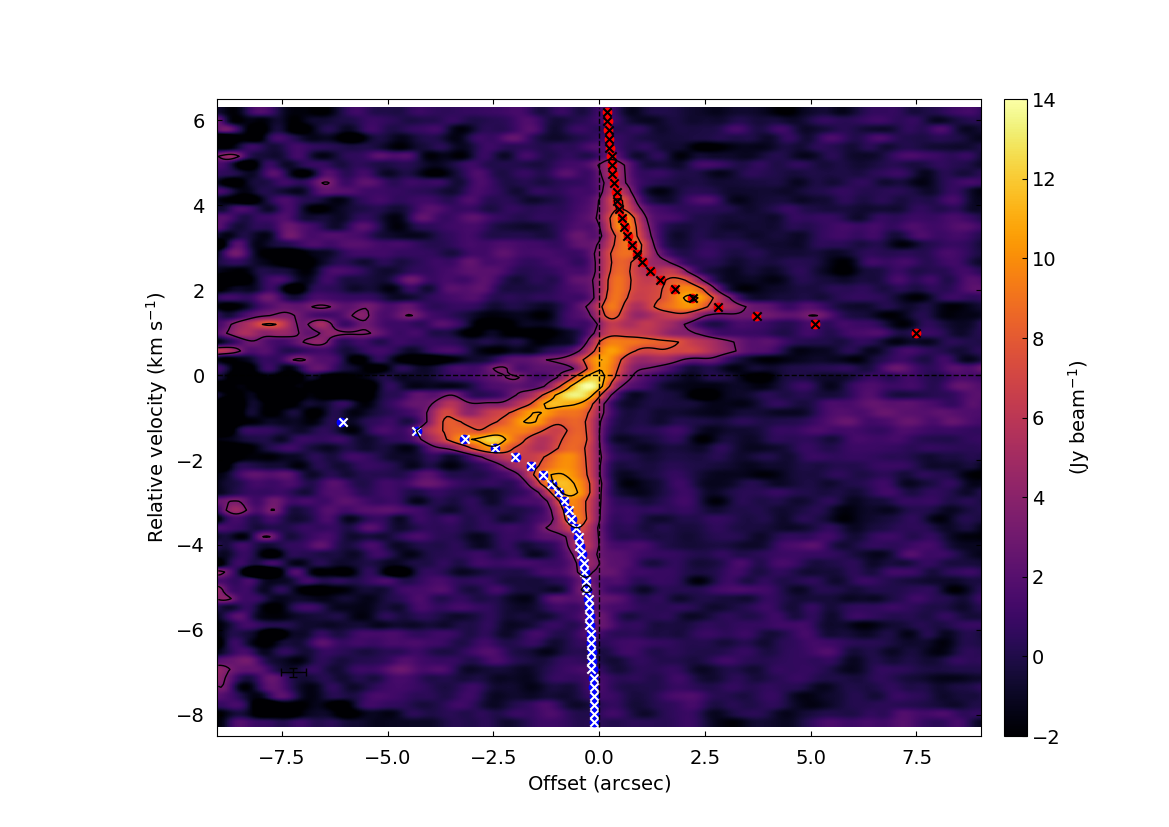

In [34]:
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### Loop over points for T estimation

In [35]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = -3.728e-01 arcsec, v = -4.43 Kmps , Tb7 = 4.3, Tb6 = 2.5


100%|██████████| 10000/10000 [00:30<00:00, 323.55it/s]


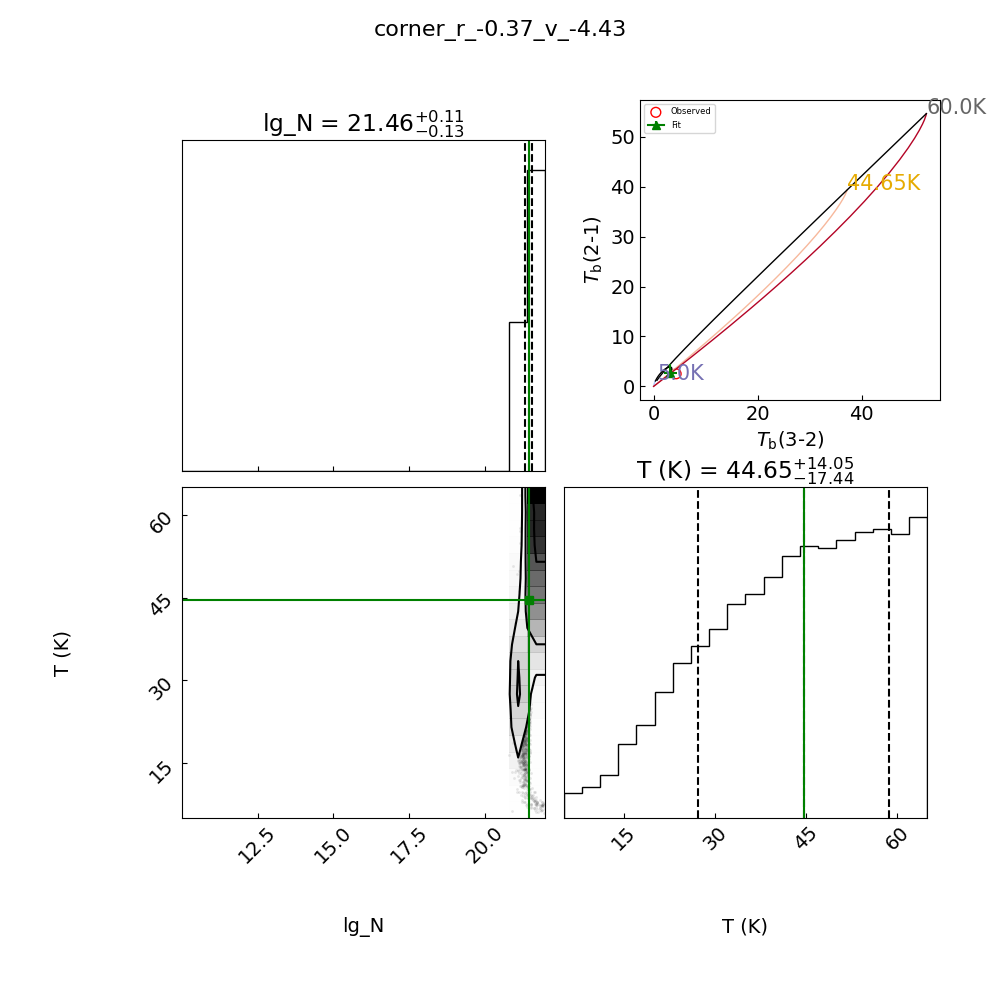

In [38]:
Texe_bs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_bs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(42)

N_conv_fraction = 1.e-7
lg_n_bounds = [10.,22.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])

op_dir_label = "blueshifted_points_empkep"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_bs"], Tb_df_b6["Tb_on_point_bs"], 
                          pv_b6.r_as_bs, pv_b6.v_rot_blueshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                     estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                     bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                     initial_scatter = 0.1, args= None,
                                     nwalkers = 50, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                     intensity_model = lte_model, plot_chain = True, 
                                     r_v_info = [str(round(r,3)), str(round(v,2))], 
                                     chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                     show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_bs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_bs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [13]:
# Calculate errorbars

T_err_empkep_bs = [np.array(Texe_bs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_bs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_bs = [np.array(Ncol_bs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_bs_empkep)]

In [14]:
results_data = {"r_empkep_bs": pv_b6.r_as_bs,
        "Tb7_empkep_bs" : Tb_df_b7["Tb_on_point_bs"], "Tb6_empkep_bs" : Tb_df_b6["Tb_on_point_bs"],
        "Texe_bs_empkep" : Texe_bs_empkep, "Texe_err_bs_empkep" : np.array(T_err_empkep_bs).T.tolist(),
        "Ncol_bs_empkep" : Ncol_bs_empkep, "Ncol_err_bs_empkep" : np.array(N_err_empkep_bs).T.tolist()
        }
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

#### Visualize results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


35 35


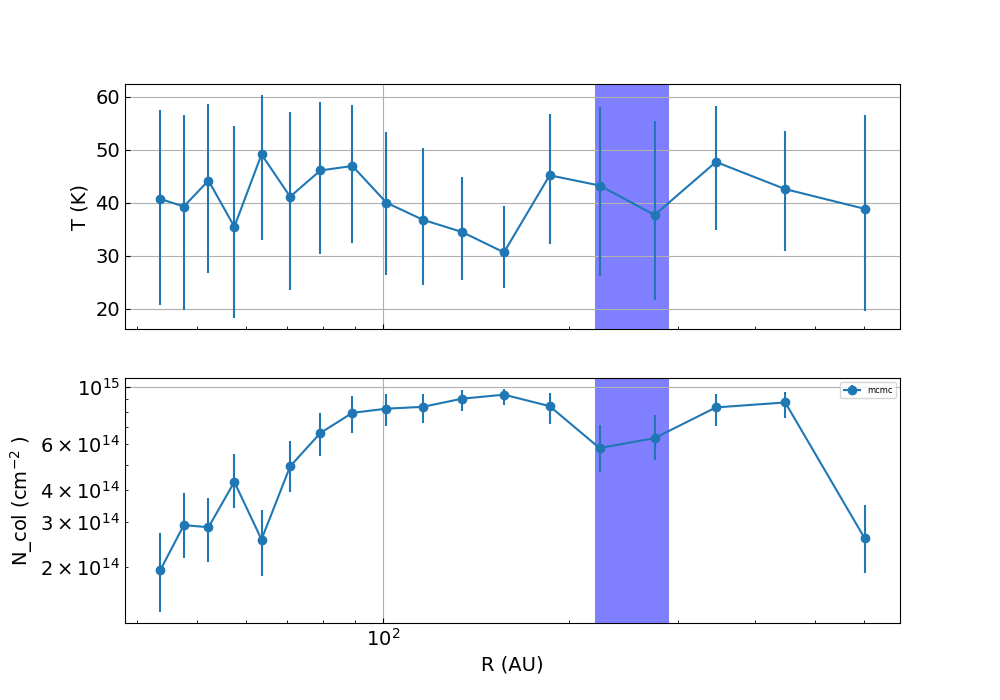

In [15]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [ -5.0, -0.3]
ftd_r_as_bs, ftd_Texe_bs_empkep, ftd_Terr_bs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_bs, Texe_bs_empkep, np.array(T_err_empkep_bs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

print(len(pv_b6.r_as_bs*140.), len(Texe_bs_empkep))
axes[0].errorbar(-np.array(ftd_r_as_bs)*140., ftd_Texe_bs_empkep, yerr=np.array(ftd_Terr_bs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_bs, ftd_Ncol_bs_empkep, ftd_N_err_bs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_bs, Ncol_bs_empkep, np.array(N_err_empkep_bs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(-np.array(ftd_r_as_bs)*140., np.array(ftd_Ncol_bs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_bs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

plt.show()

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

In [16]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [17]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r
v_100 = 3.2 #kmps
v_rot_empkep_rs_fix_r = np.sqrt(100.*np.square(v_100)/r_au_empkep_rs_fix_r)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [18]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, get_surrounding_pix = False, mode='vals',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, get_surrounding_pix = False, mode='vals',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})

#### Data Visualization

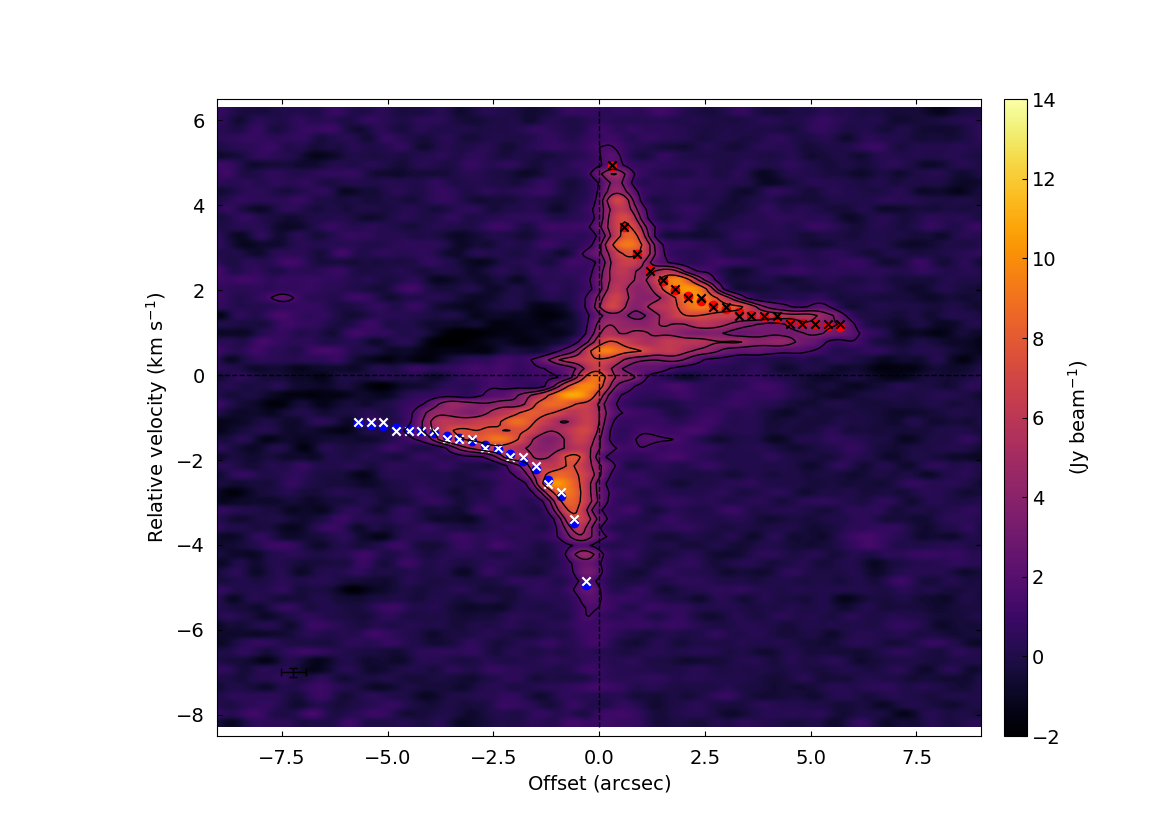

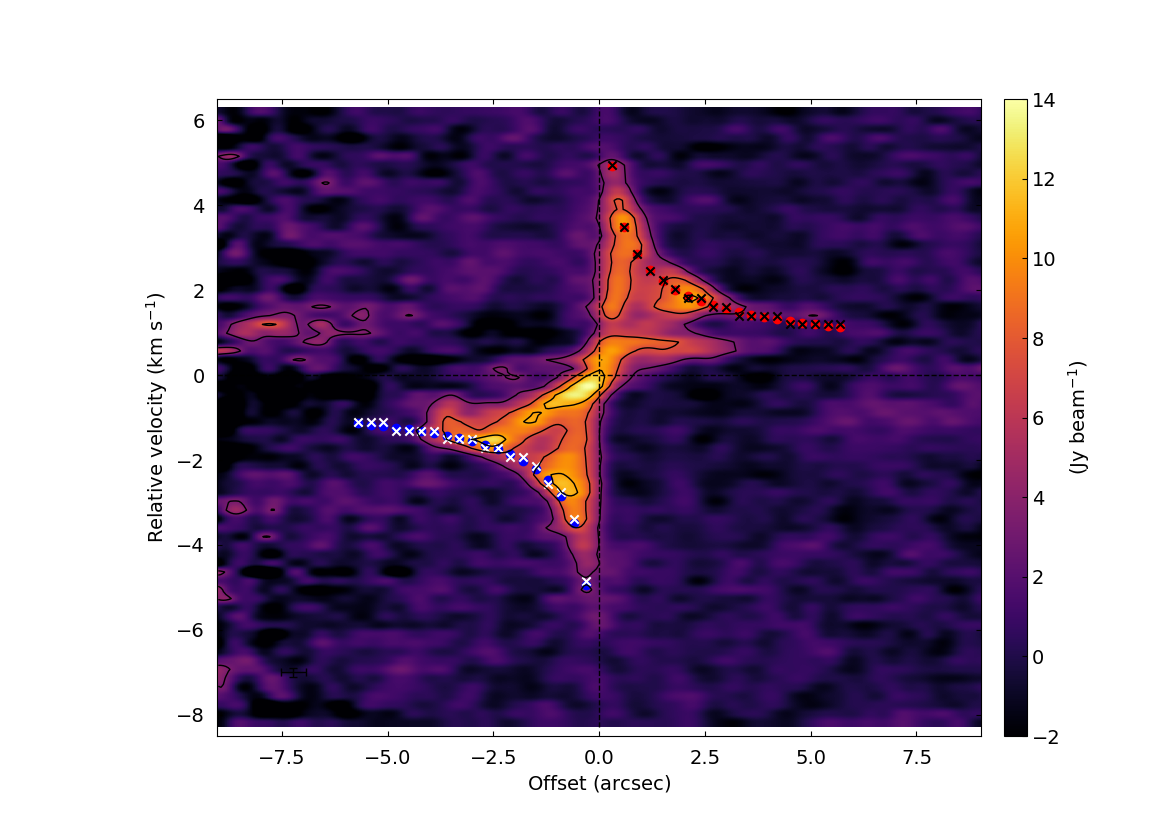

In [19]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### Loop over points for T estimation

In [20]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = -3.000e-01 arcsec, v = -4.94 Kmps , Tb7 = 3.0, Tb6 = 1.9


100%|██████████| 10000/10000 [01:30<00:00, 110.31it/s]


estimating for r = -6.000e-01 arcsec, v = -3.49 Kmps , Tb7 = 9.5, Tb6 = 6.8


100%|██████████| 10000/10000 [01:30<00:00, 110.79it/s]


estimating for r = -9.000e-01 arcsec, v = -2.85 Kmps , Tb7 = 10.7, Tb6 = 9.0


100%|██████████| 10000/10000 [01:26<00:00, 114.95it/s]


estimating for r = -1.200e+00 arcsec, v = -2.47 Kmps , Tb7 = 9.8, Tb6 = 9.2


100%|██████████| 10000/10000 [01:27<00:00, 114.45it/s]


estimating for r = -1.500e+00 arcsec, v = -2.21 Kmps , Tb7 = 7.2, Tb6 = 5.8


100%|██████████| 10000/10000 [01:24<00:00, 118.03it/s]


estimating for r = -1.800e+00 arcsec, v = -2.02 Kmps , Tb7 = 6.4, Tb6 = 5.9


100%|██████████| 10000/10000 [01:20<00:00, 124.12it/s]


estimating for r = -2.100e+00 arcsec, v = -1.87 Kmps , Tb7 = 6.4, Tb6 = 5.8


100%|██████████| 10000/10000 [01:21<00:00, 123.42it/s]


estimating for r = -2.400e+00 arcsec, v = -1.75 Kmps , Tb7 = 10.0, Tb6 = 6.5


100%|██████████| 10000/10000 [01:19<00:00, 125.25it/s]


estimating for r = -2.700e+00 arcsec, v = -1.65 Kmps , Tb7 = 9.8, Tb6 = 6.2


100%|██████████| 10000/10000 [01:20<00:00, 124.70it/s]


estimating for r = -3.000e+00 arcsec, v = -1.56 Kmps , Tb7 = 10.8, Tb6 = 7.7


100%|██████████| 10000/10000 [01:26<00:00, 115.67it/s]


estimating for r = -3.300e+00 arcsec, v = -1.49 Kmps , Tb7 = 10.0, Tb6 = 7.1


100%|██████████| 10000/10000 [01:25<00:00, 116.43it/s]


estimating for r = -3.600e+00 arcsec, v = -1.43 Kmps , Tb7 = 7.6, Tb6 = 6.3


100%|██████████| 10000/10000 [01:24<00:00, 118.20it/s]


estimating for r = -3.900e+00 arcsec, v = -1.37 Kmps , Tb7 = 6.5, Tb6 = 5.1


100%|██████████| 10000/10000 [01:25<00:00, 117.12it/s]


estimating for r = -4.200e+00 arcsec, v = -1.32 Kmps , Tb7 = 4.4, Tb6 = 3.3


100%|██████████| 10000/10000 [01:25<00:00, 117.58it/s]


estimating for r = -4.500e+00 arcsec, v = -1.27 Kmps , Tb7 = 1.7, Tb6 = 1.9


100%|██████████| 10000/10000 [01:21<00:00, 123.33it/s]


estimating for r = -4.800e+00 arcsec, v = -1.23 Kmps , Tb7 = 1.0, Tb6 = 0.6


100%|██████████| 10000/10000 [00:26<00:00, 376.83it/s]


estimating for r = -5.100e+00 arcsec, v = -1.20 Kmps , Tb7 = 0.8, Tb6 = 0.2


100%|██████████| 10000/10000 [00:26<00:00, 377.12it/s]


estimating for r = -5.400e+00 arcsec, v = -1.16 Kmps , Tb7 = 0.4, Tb6 = 0.8


100%|██████████| 10000/10000 [00:26<00:00, 379.99it/s]


estimating for r = -5.700e+00 arcsec, v = -1.13 Kmps , Tb7 = -0.5, Tb6 = -0.3


100%|██████████| 10000/10000 [00:26<00:00, 372.55it/s]


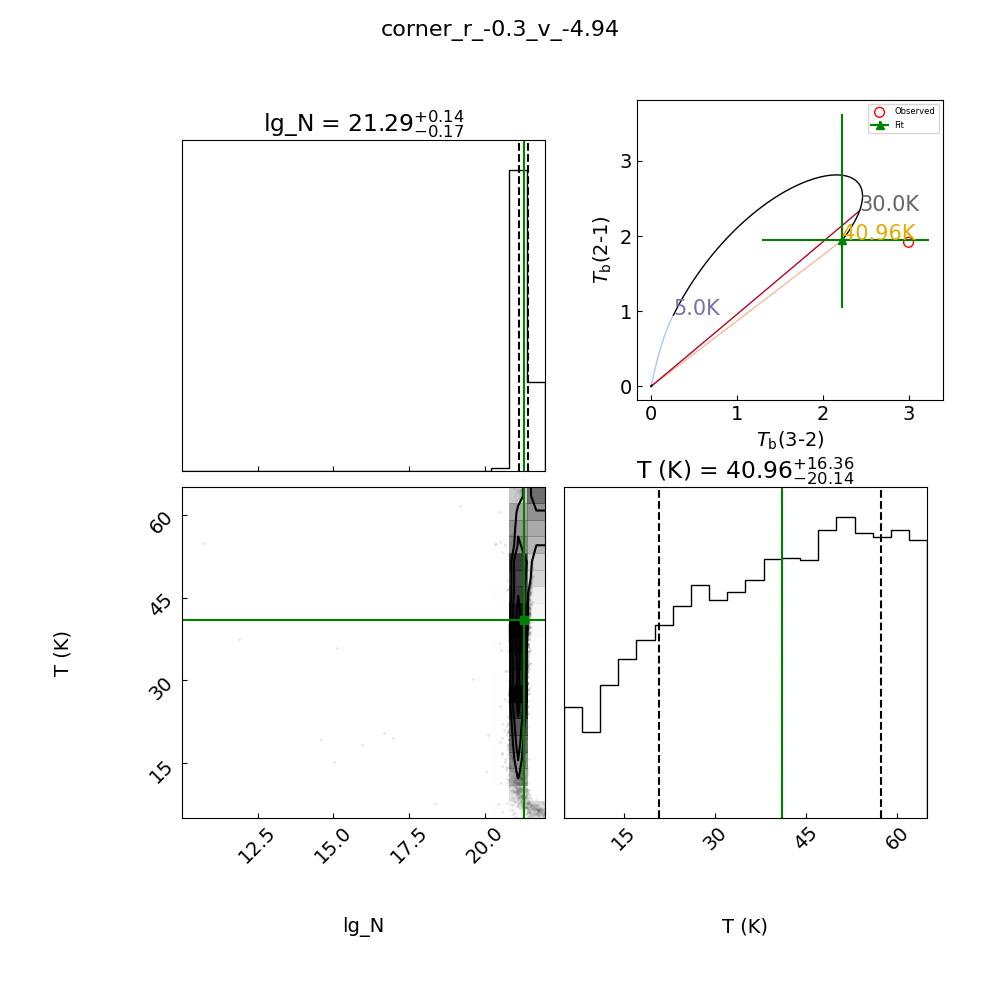

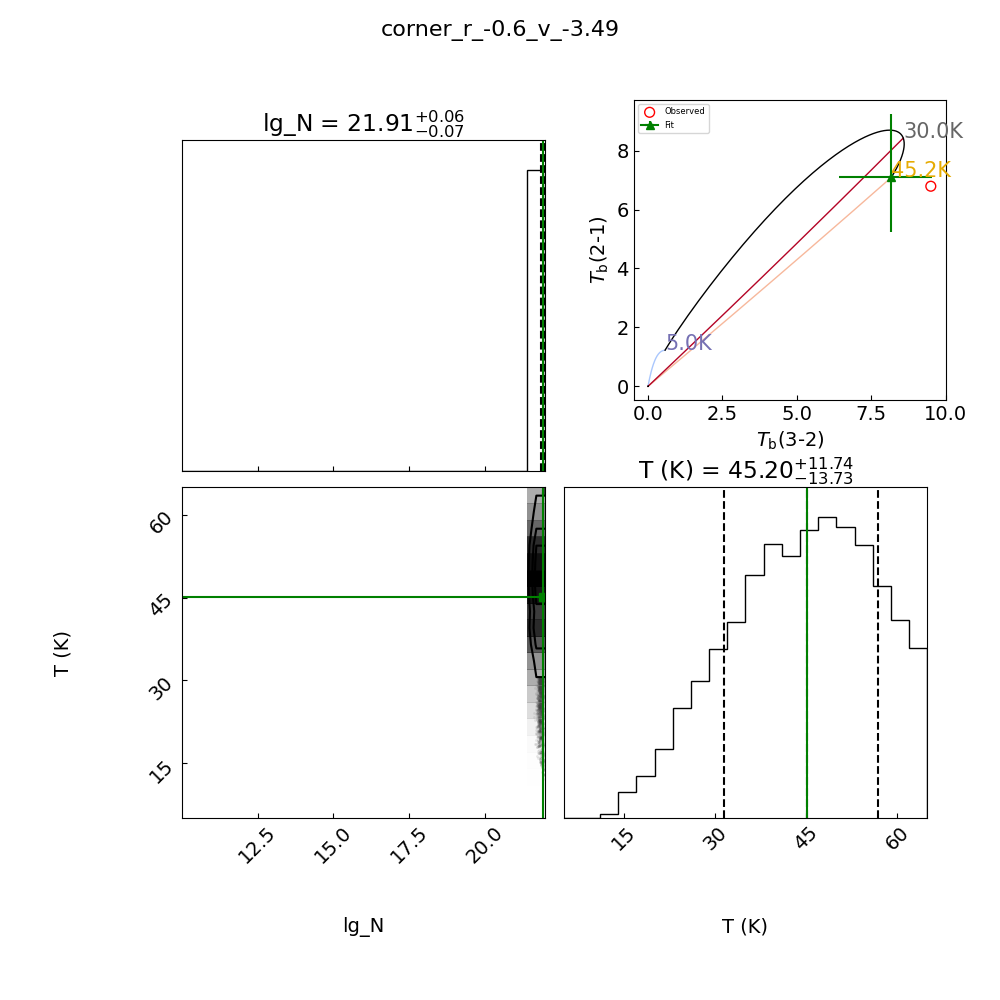

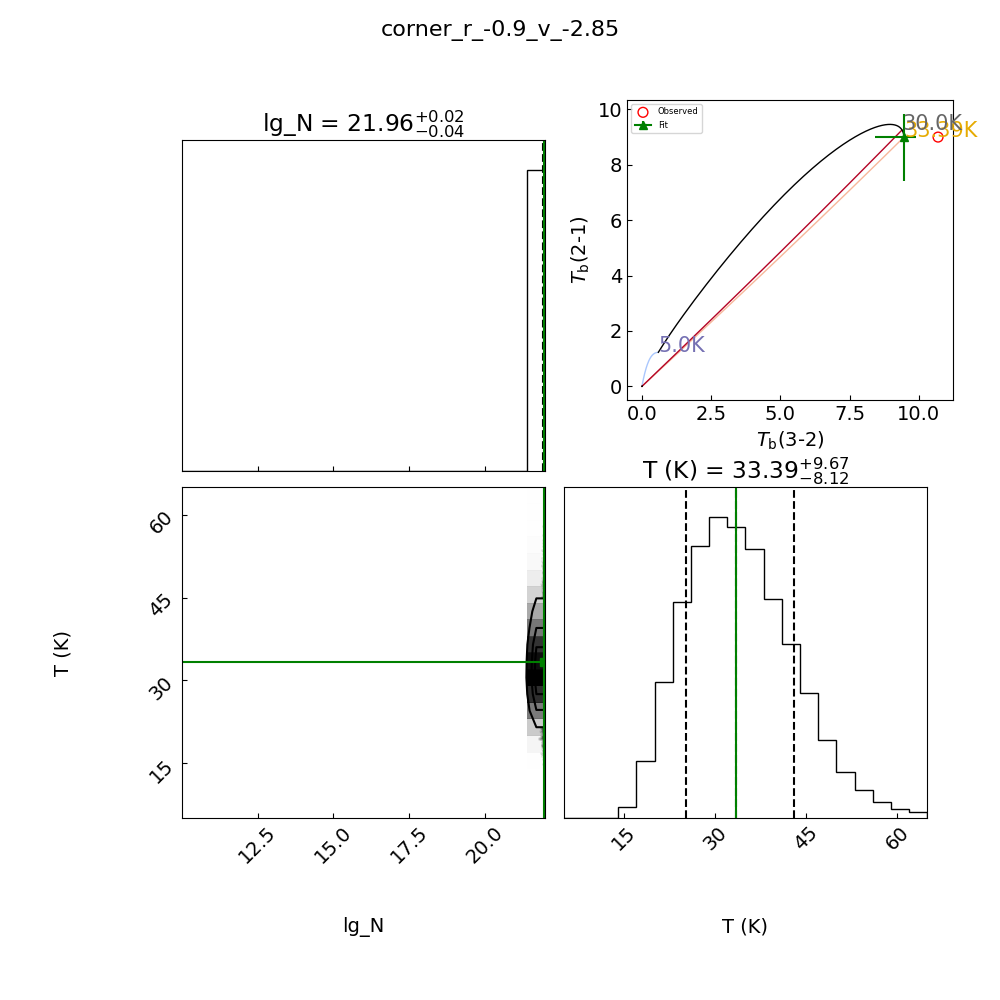

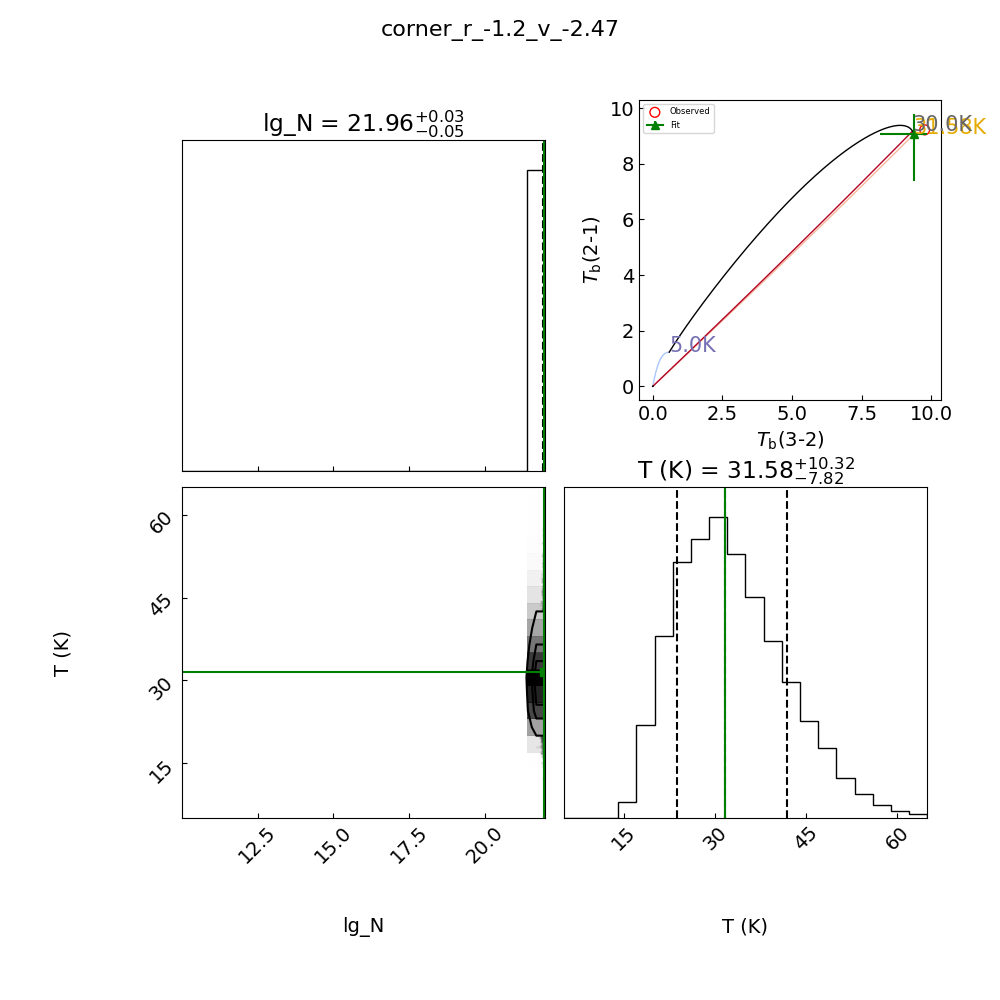

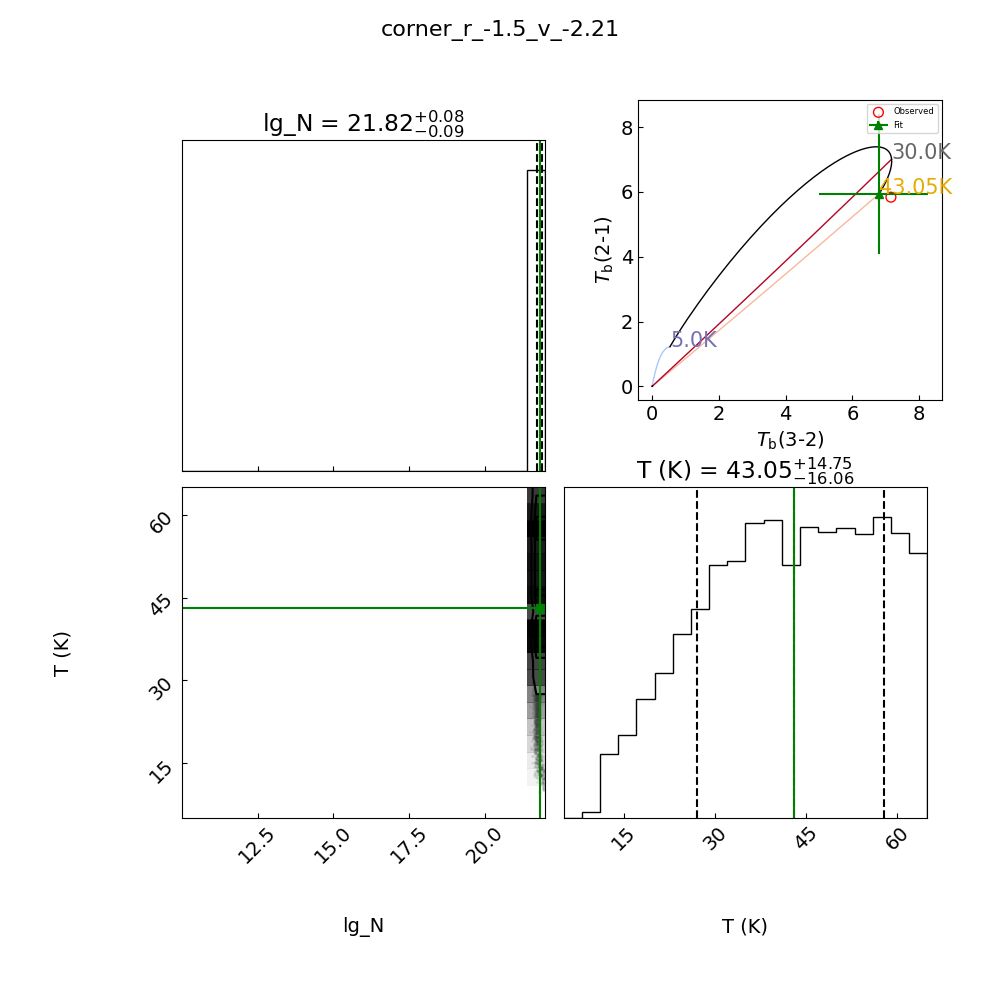

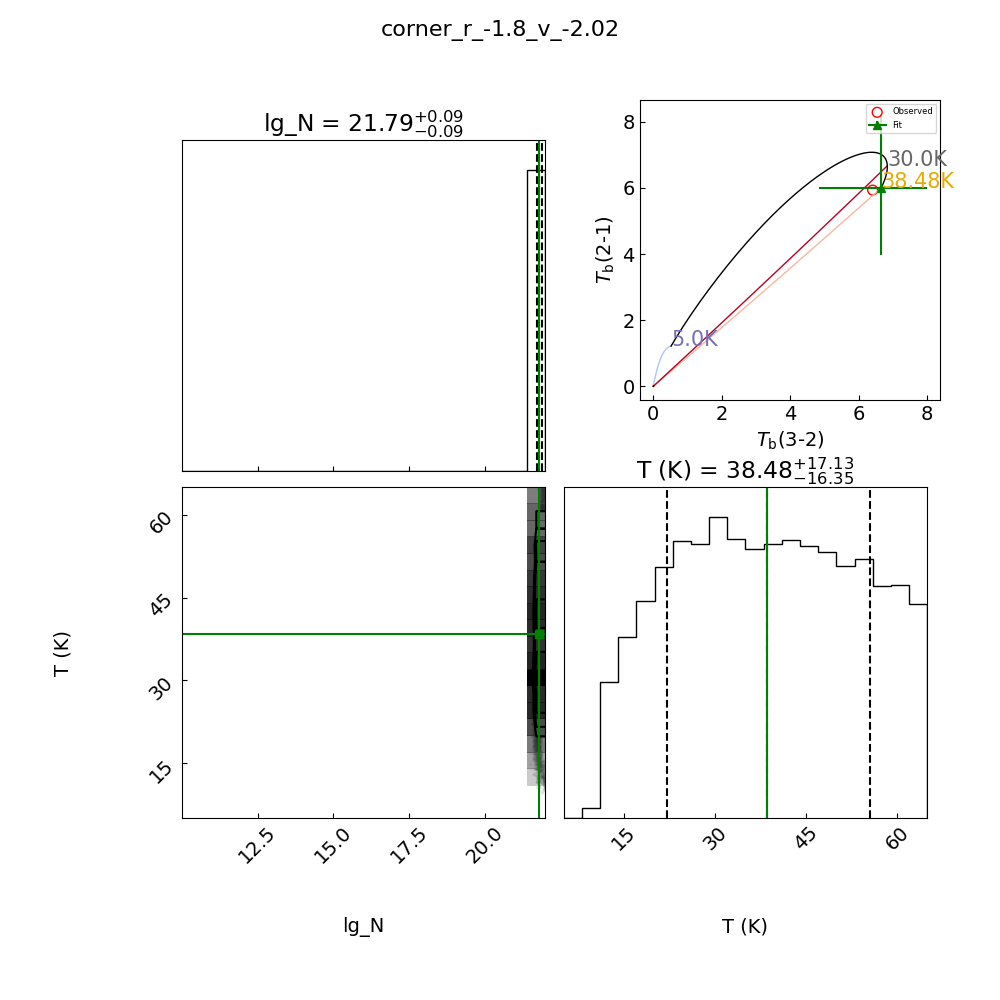

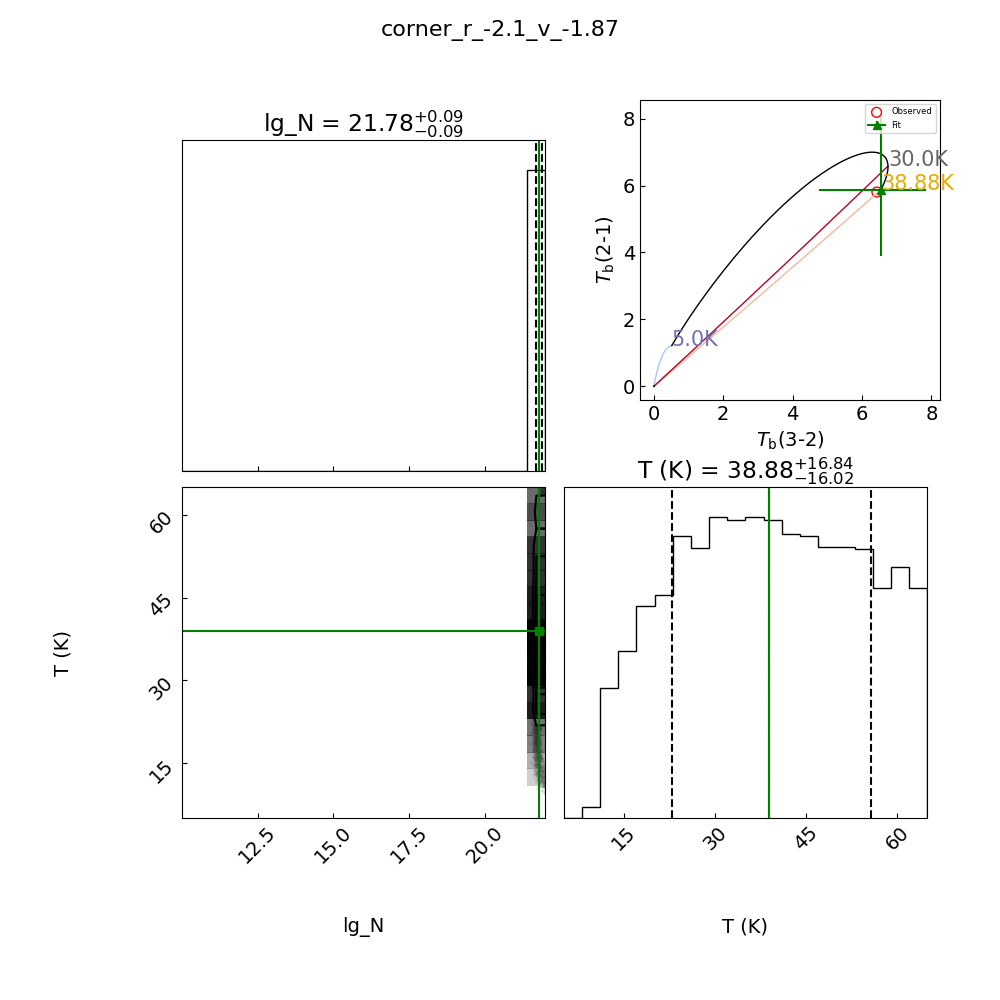

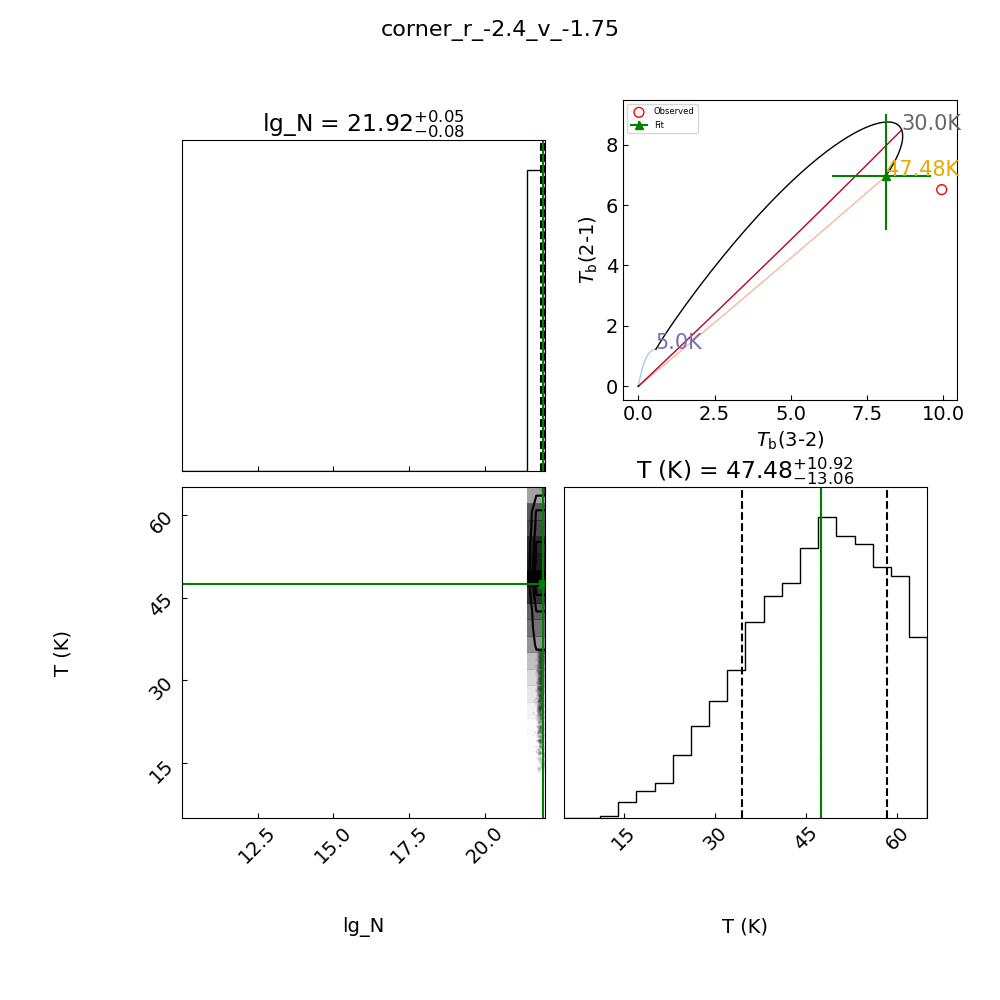

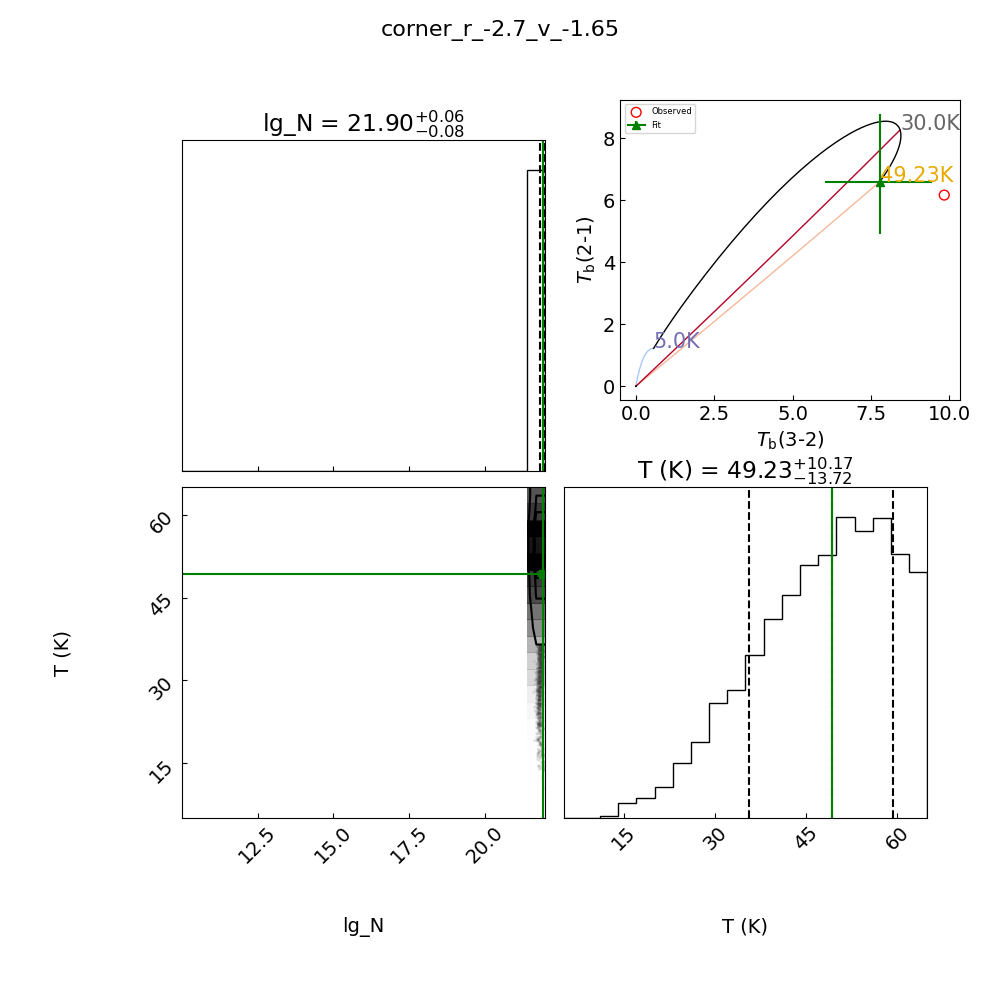

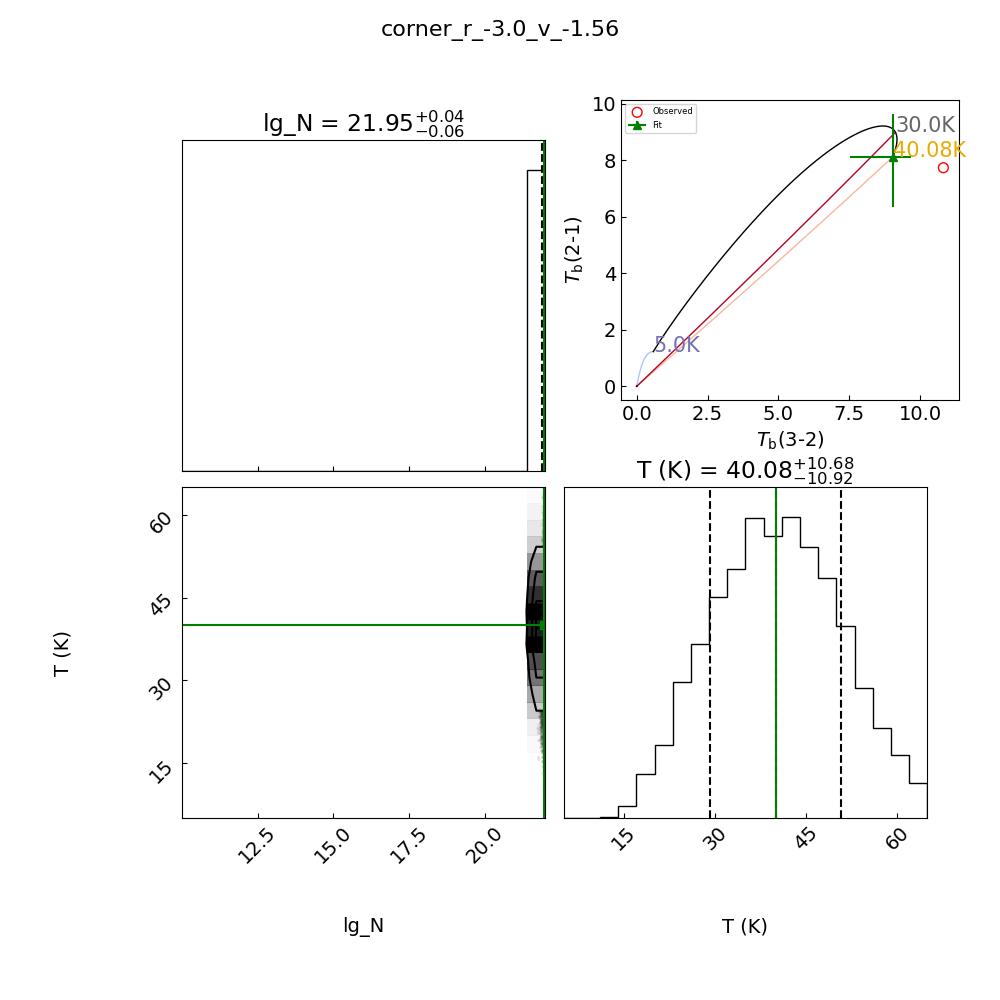

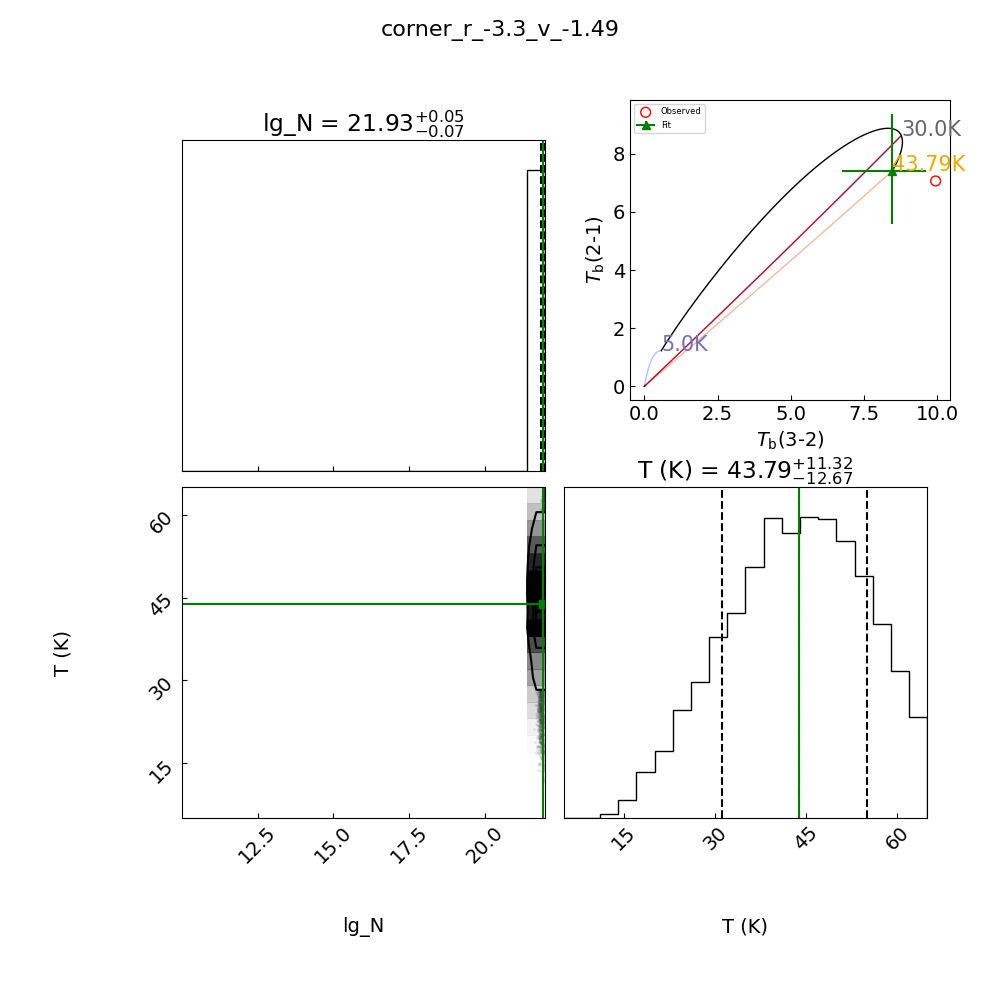

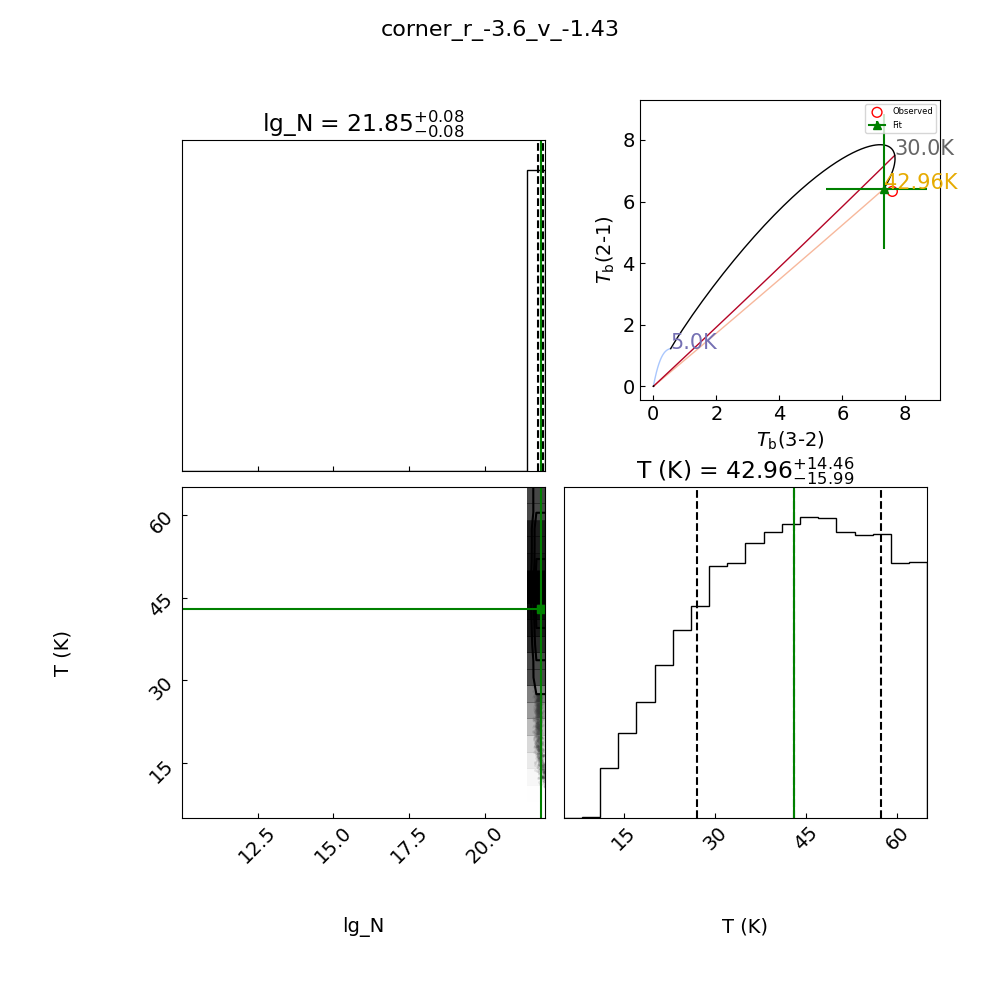

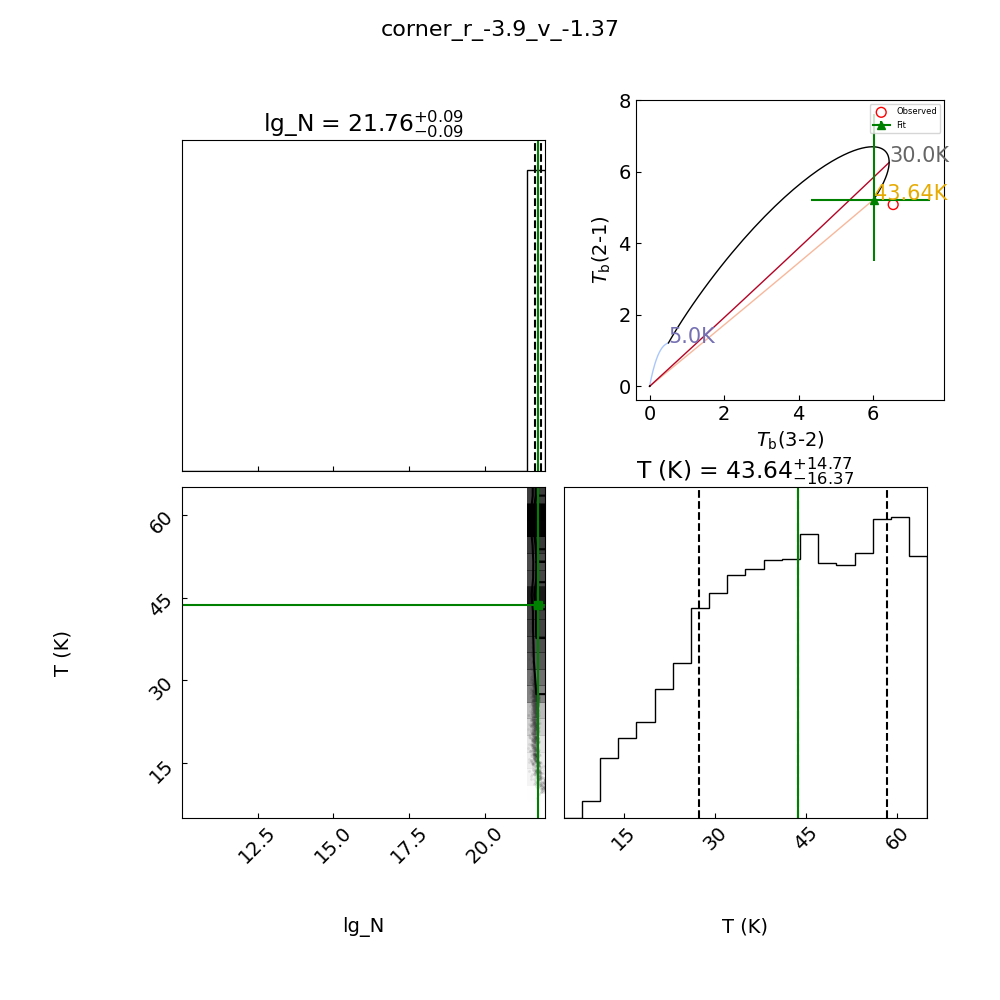

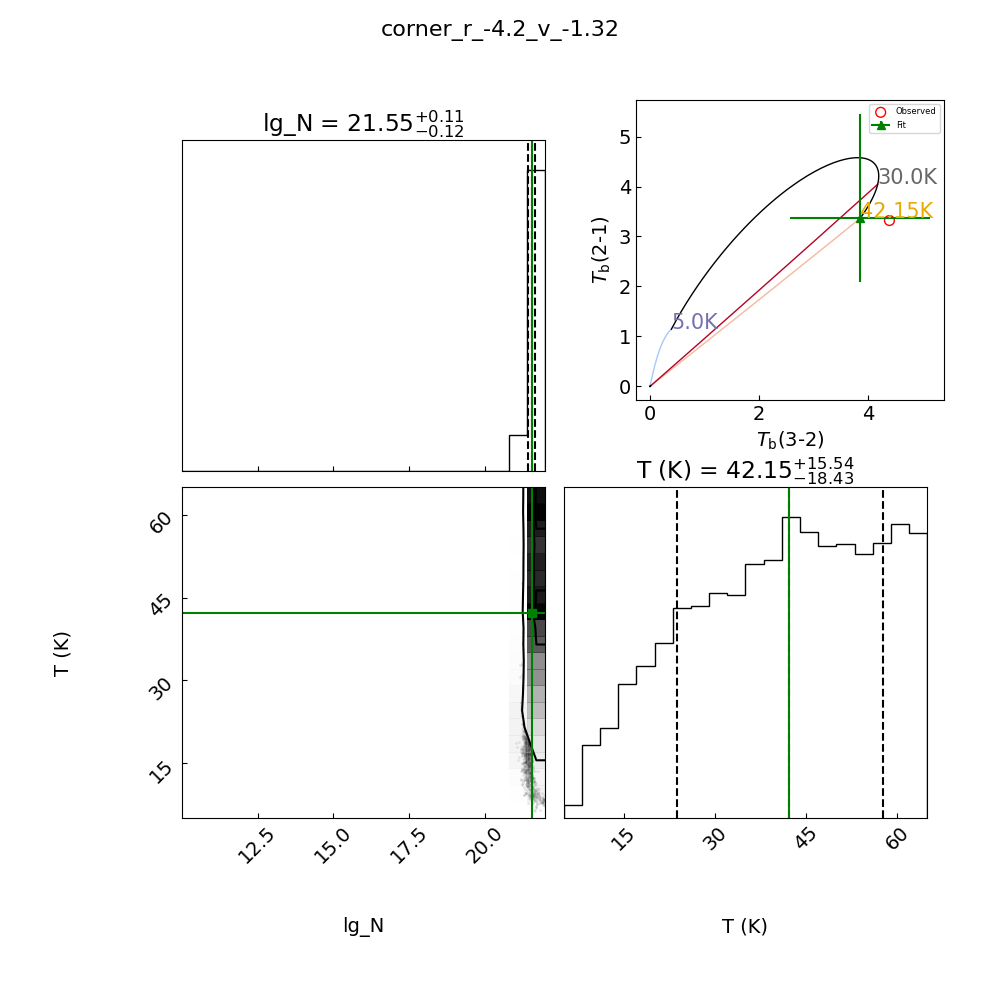

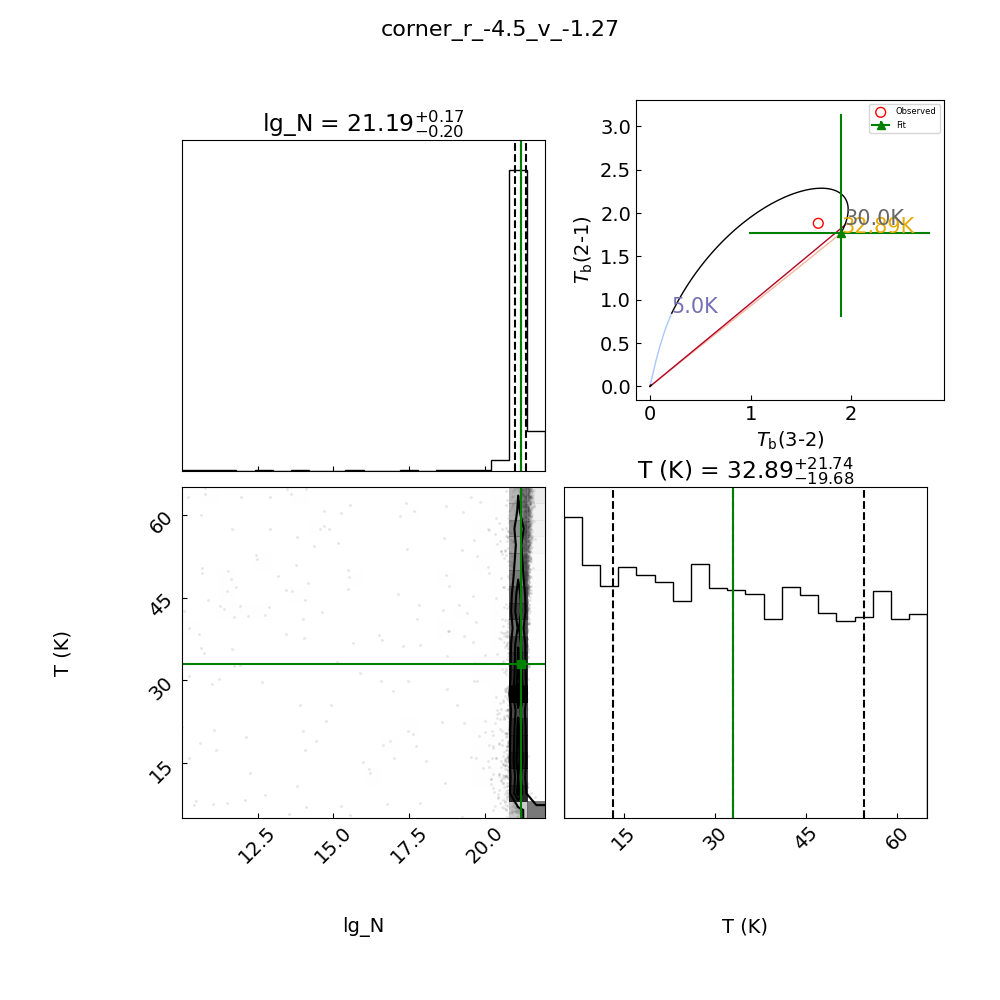

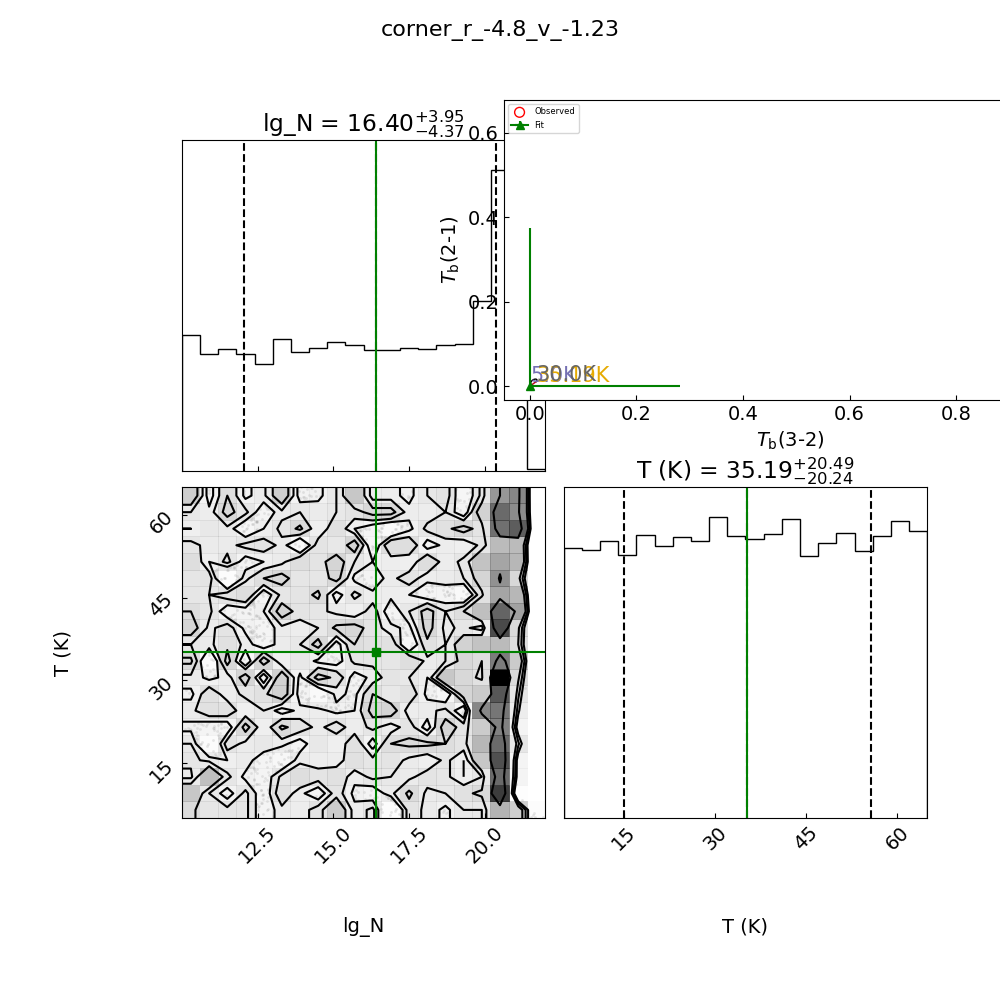

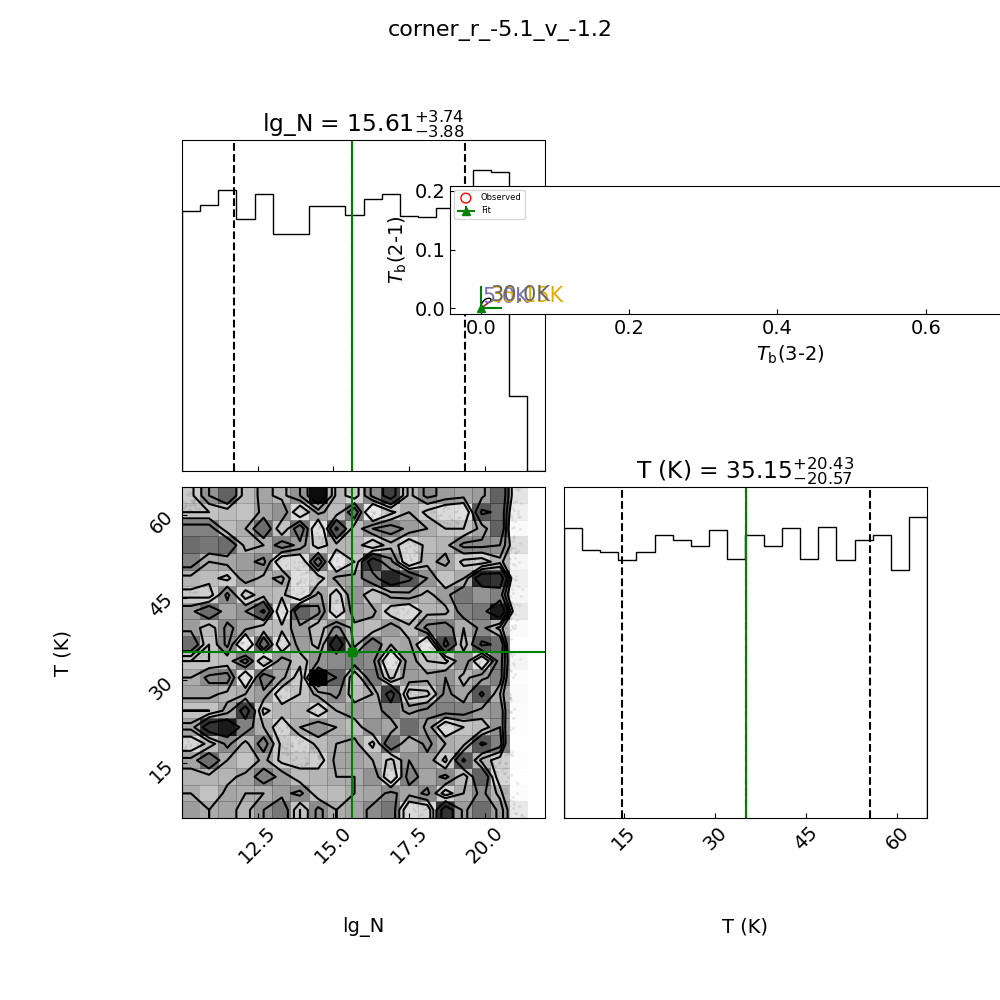

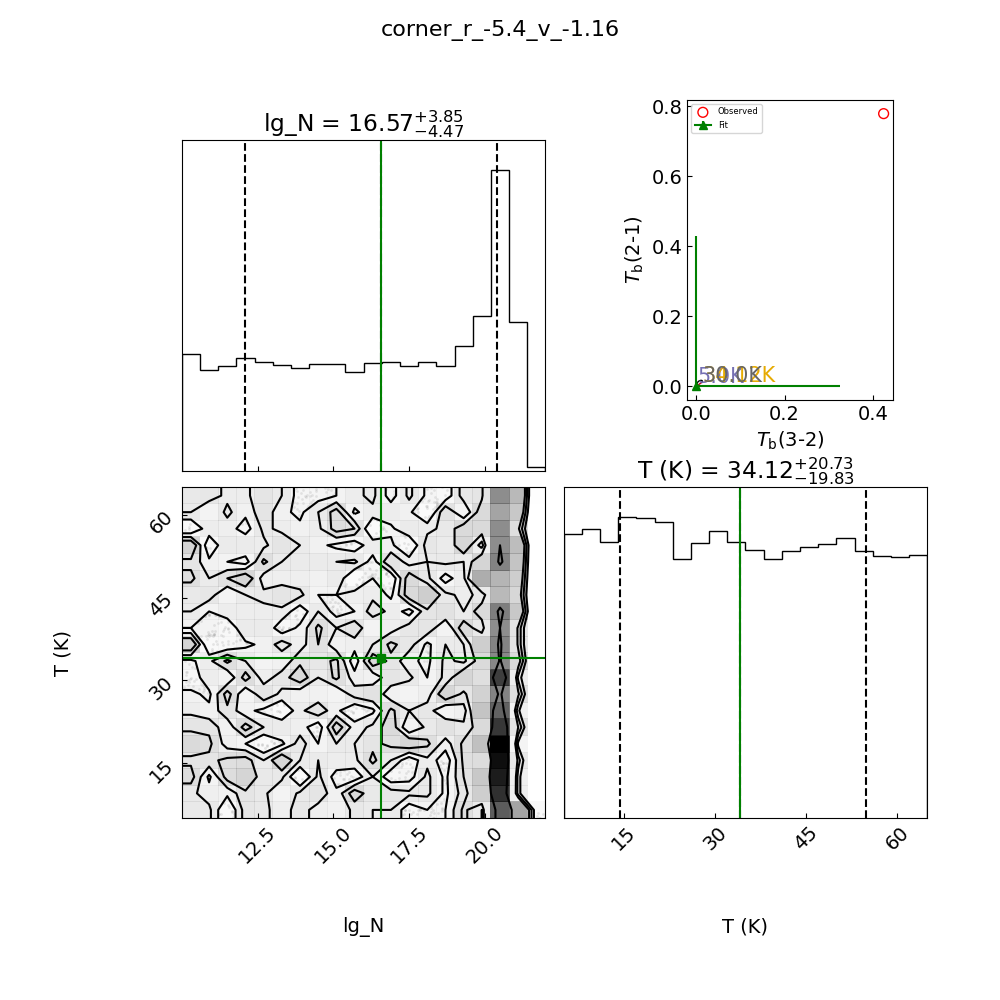

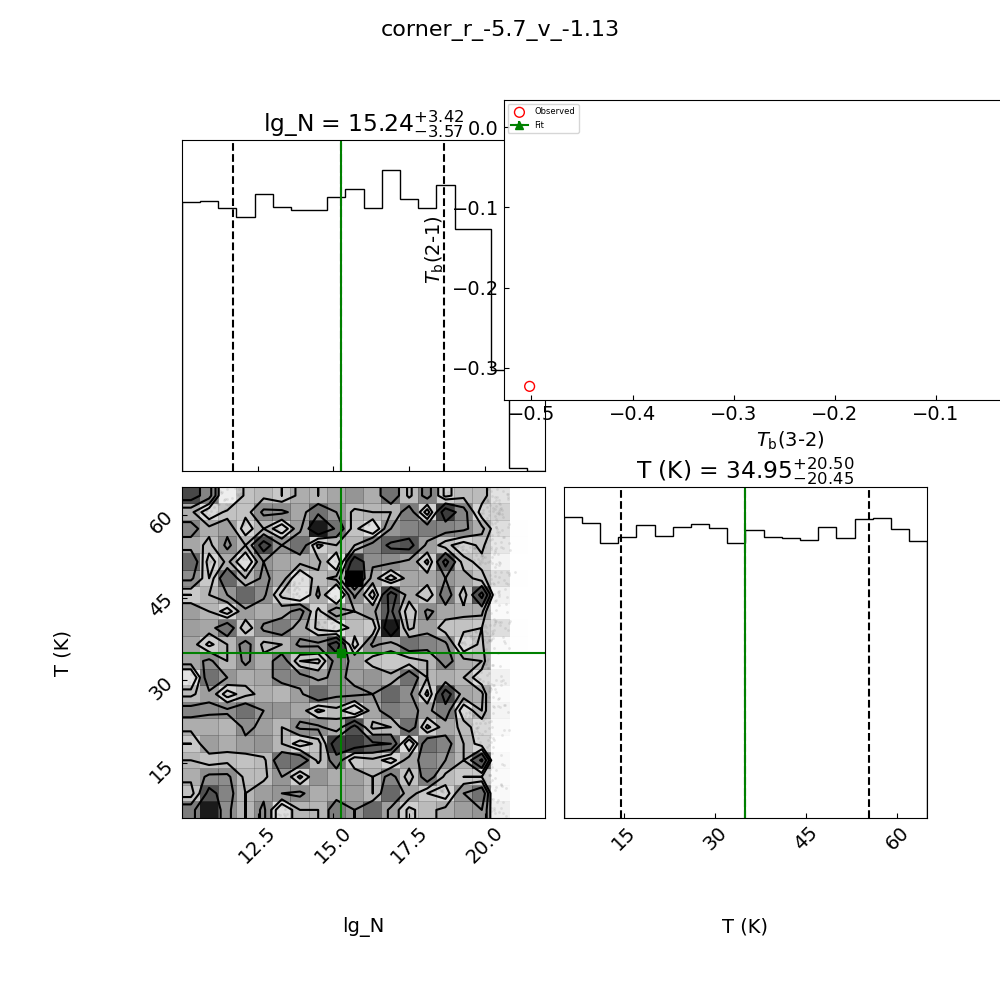

In [21]:
Texe_bs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_bs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [10.,22.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])

op_dir_label = "blueshifted_points_empkep_fix_r"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_bs"], Tb_df_b6["Tb_on_point_bs"], 
                          pv_b6.r_as_bs, pv_b6.v_rot_blueshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                     estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                     bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                     initial_scatter = 0.1, args= None,
                                     nwalkers = 50, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                     intensity_model = lte_model, plot_chain = True, 
                                     r_v_info = [str(round(r,3)), str(round(v,2))], 
                                     chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                    "chains",op_dir_label),
                                     show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep_fix_r.append(T_qtls[0])
    Texe_bs_empkep_fix_r.append(T_qtls[1])
    Texe_upq_empkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
    Ncol_bs_empkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [22]:
# Calculate errorbars

T_err_empkep_bs_fix_r = [np.array(Texe_bs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_bs_empkep_fix_r)] 

N_err_empkep_bs_fix_r = [np.array(Ncol_bs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_bs_empkep_fix_r)]

In [23]:
results_data_fix_r = {"r_empkep_bs_fix_r": pv_b6.r_as_bs,
        "Tb7_empkep_bs_fix_r" : Tb_df_b7["Tb_on_point_bs"], "Tb6_empkep_bs_fix_r" : Tb_df_b6["Tb_on_point_bs"],
        "Texe_bs_empkep_fix_r" : Texe_bs_empkep_fix_r, "Texe_err_bs_empkep_fix_r" : np.array(T_err_empkep_bs_fix_r).T.tolist(),
        "Ncol_bs_empkep_fix_r" : Ncol_bs_empkep_fix_r, "Ncol_err_bs_empkep_fix_r" : np.array(N_err_empkep_bs_fix_r).T.tolist()
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")

if not os.path.exists(res_path):

        empty_df = pd.DataFrame()
        empty_df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

#### Visualize results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


19 19


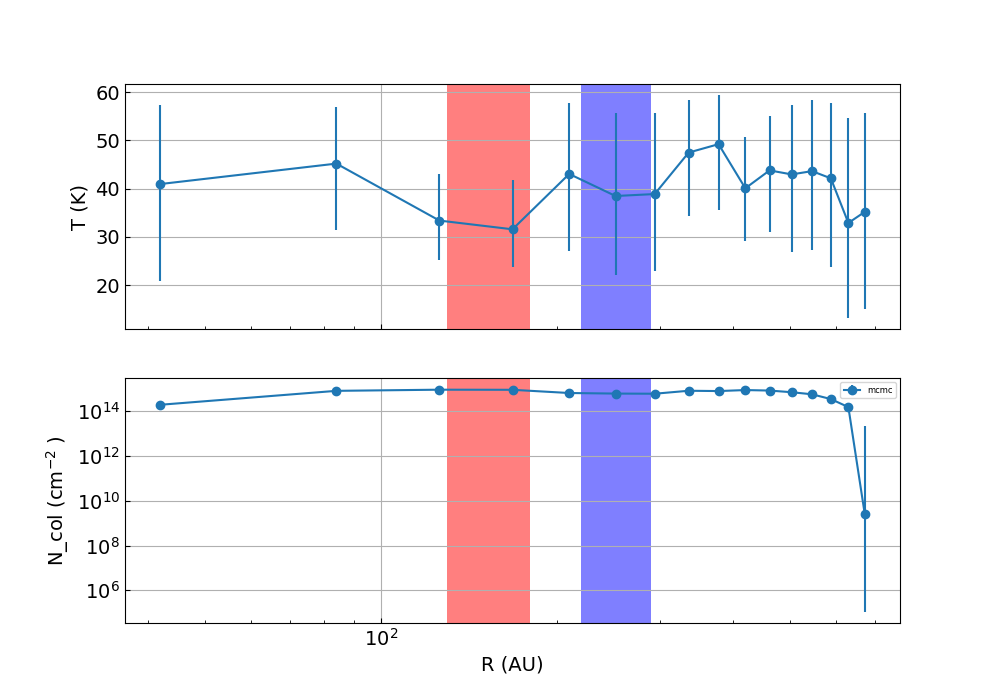

In [24]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [-5.0, -0.3]
ftd_r_as_bs_fix_r, ftd_Texe_bs_empkep_fix_r, ftd_Terr_bs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_bs, Texe_bs_empkep_fix_r, np.array(T_err_empkep_bs_fix_r).T.tolist())
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

print(len(pv_b6.r_as_bs*140.), len(Texe_bs_empkep_fix_r))
axes[0].errorbar(-np.array(ftd_r_as_bs_fix_r)*140., ftd_Texe_bs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_bs_empkep_fix_r).T, marker='o', label = 'mcmc')

axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[0].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_bs_fix_r, ftd_Ncol_bs_empkep_fix_r, ftd_N_err_bs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_bs, Ncol_bs_empkep_fix_r, np.array(N_err_empkep_bs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])


axes[1].errorbar(-np.array(ftd_r_as_bs_fix_r)*140., np.array(ftd_Ncol_bs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_bs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')